# Poisson matrix factorization


**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Winter, 2021._

---

**Poisson matrix factorization** is a probabilistic model for non-negative matrix factorization. Let $\mathbf{X} \in \mathbb{N}^{N \times M}$ denote a count matrix with entries $x_{n,m}$. We model each entry as a Poisson random variable,
\begin{align}
x_{n,m} &\sim \mathrm{Po}\Big(\boldsymbol{\theta}_{n}^\top \boldsymbol{\eta}_{m} \Big)
= \mathrm{Po}\Big(\sum_{k=1}^K \theta_{n,k} \eta_{m,k} \Big),
\end{align}
where $\boldsymbol{\theta}_{n} \in \mathbb{R}_+^K$ and $\boldsymbol{\eta}_{n} \in \mathbb{R}_+^K$ are _non-negative_ feature vectors for row $n$ and column $m$, respectively. 

PMF has been used for recommender systems, aka collaborative filtering. In a recommender system, the rows correspond to users, the columns to items, and the entries $x_{n,m}$ to how much user $n$ liked item $m$ (on a scale of $0,1,2,\ldots$ stars, for example). The $K$ feature dimensions capture different aspects of items that users may weight in their ratings.

Note that the Poisson rate must be non-negative. It is sufficient to ensure $\boldsymbol{\theta}_{n}$ and $\boldsymbol{\eta}_{m}$ are non-negative. To that end, PMF places a gamma prior,
\begin{align}
\theta_{n,k} &\sim \mathrm{Ga}(\alpha_\theta, \beta_\theta) \\
\eta_{m,k} &\sim \mathrm{Ga}(\alpha_\eta, \beta_\eta),
\end{align}
where $\alpha_\star$ and $\beta_\star$ are hyperparameters. When $\alpha_\star < 1$, the gamma distribution has a sharp peak at zero and the prior induces sparsity in the feature vectors.

## Latent variable formulation
PMF can be rewritten in terms of a latent variable model. Note that,
\begin{align}
x_{n,m} \sim \mathrm{Po}\Big(\sum_{k=1}^K \theta_{n,k} \eta_{m,k} \Big)
\iff x_{n,m} &= \sum_{k=1}^K z_{n,m,k} \\
z_{n,m,k} &\sim \mathrm{Po}(\theta_{nk} \eta_{mk}) \quad \text{independently}.
\end{align}
From this perspective, a user's rating of an item is a sum of ratings along each feature dimension, and each feature rating is an independent Poisson random variable. 

The joint distribution is,
\begin{align}
p(\mathbf{X}, \mathbf{Z}, \boldsymbol{\Theta}, \mathbf{H}) 
= 
\left[\prod_{n=1}^N \prod_{m=1}^M \mathbb{I}\Big[x_{n,m}=\sum_{k=1}^K z_{n,m,k} \Big] 
\prod_{k=1}^K \mathrm{Po}(z_{n,m,k} \mid \theta_{n,k} \eta_{m,k}) 
\right] 
\times \left[ \prod_{n=1}^N \prod_{k=1}^K \mathrm{Ga}(\theta_{n,k} \mid \alpha_\theta, \beta_\theta) \right]
\times \left[ \prod_{m=1}^M \prod_{k=1}^K \mathrm{Ga}(\eta_{m,k} \mid \alpha_\eta, \beta_\eta) \right]
\end{align}
where $\mathbf{Z} \in \mathbb{N}^{N\times M \times K}$ denotes the _tensor_ of feature ratings, $\boldsymbol{\Theta} \in \mathbb{R}_+^{N \times K}$ is a matrix with rows $\boldsymbol{\theta}_n$, and $\mathbf{H} \in \mathbb{R}_+^{M \times K}$ is a matrix with rows $\boldsymbol{\eta}_m$. 

## Conditional distributions

Since this model is constructed from conjugate exponential family distributions, the conditionals are available in closed form. Letting $\mathbf{z}_{n,m} = (z_{n,m,1}, \ldots, z_{n,m,K})$, we have,
\begin{align}
p(\mathbf{z}_{n,m} \mid x_{n,m}, \boldsymbol{\theta}_{n}, \boldsymbol{\eta}_{m}) 
&\propto\mathbb{I}\Big[x_{n,m}=\sum_{k=1}^K z_{n,m,k} \Big] 
\prod_{k=1}^K \mathrm{Po}(z_{n,m,k} \mid \theta_{n,k} \eta_{m,k}) \\
&\propto \mathbb{I}\Big[x_{n,m}=\sum_{k=1}^K z_{n,m,k} \Big] 
\prod_{k=1}^K \frac{1}{z_{n,m,k}!} (\theta_{n,k} \eta_{m,k})^{z_{n,m,k}} \\
&\propto
\mathrm{Mult}( \mathbf{z}_{n,m} \mid x_{n,m}, \boldsymbol{\pi}_{n,m}) \\
\boldsymbol{\pi}_{n,m} &= \left(\frac{\theta_{n,1}\eta_{m,1}}{\boldsymbol{\theta}_n^\top \boldsymbol{\eta}_m}, \ldots, \frac{\theta_{n,K}\eta_{m,K}}{\boldsymbol{\theta}_n^\top \boldsymbol{\eta}_m} \right)
\end{align}
For the per-user parameters,
\begin{align}
p(\theta_{n,k} \mid \mathbf{Z}, \mathbf{H}) 
&\propto \left[ \prod_{m=1}^M \mathrm{Po}(z_{n,m,k} \mid \theta_{n,k} \eta_{m,k}) \right] \mathrm{Ga}(\theta_{n,k} \mid \alpha_\theta, \beta_\theta) \\
&\propto \left[ \prod_{m=1}^M (\theta_{n,k} \eta_{m,k})^{z_{n,m,k}} e^{-\theta_{n,k} \eta_{m,k}} \right] \mathrm{Ga}(\theta_{n,k} \mid \alpha_\theta, \beta_\theta) \\
&\propto \mathrm{Ga} \Big(\theta_{n,k} \mid \alpha_{\theta} + \sum_{m=1}^M z_{n,m,k}, \, \beta_\theta + \sum_{m=1}^M \eta_{m,k} \Big),
\end{align}
and by symmetry
\begin{align}
p(\eta_{n,k} \mid \mathbf{Z}, \boldsymbol{\Theta})
&\propto \mathrm{Ga} \Big(\eta_{m,k} \mid \alpha_{\eta} + \sum_{n=1}^N z_{n,m,k}, \, \beta_\eta + \sum_{n=1}^N \theta_{n,k} \Big).
\end{align}

## Coordinate ascent variational inference

The optimal mean field factors have the same forms as the conditional distributions above.

**Exercise:** Show that,
\begin{align}
q(\mathbf{z}_{n,m}; \boldsymbol{\lambda}^{(z)}_{n,m}) 
&= \mathrm{Mult}(\mathbf{z}_{n,m}; x_{n,m}, \boldsymbol{\lambda}^{(z)}_{n,m}) \\
\log \lambda^{(z)}_{n,m,k} &= \mathbb{E}_q[\log \theta_{n,k} + \log \eta_{m,k}] + c
\end{align}
and
\begin{align}
q(\theta_{n,k}; {\lambda}^{(\theta)}_{n,k,1}, {\lambda}^{(\theta)}_{n,k,2}) 
&= \mathrm{Ga}(\theta_{n,k}; {\lambda}^{(\theta)}_{n,k,1}, {\lambda}^{(\theta)}_{n,k,2}) \\
{\lambda}^{(\theta)}_{n,k,1} &=  \alpha_\theta + \sum_{m=1}^M \mathbb{E}_q[z_{n,m,k}] \\
{\lambda}^{(\theta)}_{n,k,2} &=  \beta_\theta + \sum_{m=1}^M \mathbb{E}_q[\eta_{m,k}] 
\end{align}
and
\begin{align}
q(\eta_{m,k}; {\lambda}^{(\eta)}_{m,k,1}, {\lambda}^{(\eta)}_{m,k,2}) 
&= \mathrm{Ga}(\eta_{m,k}; {\lambda}^{(\eta)}_{m,k,1}, \lambda^{(\eta)}_{m,k,2}) \\
{\lambda}^{(\eta)}_{m,k,1} &=  \alpha_\eta + \sum_{n=1}^N \mathbb{E}_q[z_{n,m,k}] \\
{\lambda}^{(\eta)}_{m,k,2} &=  \beta_\eta + \sum_{n=1}^N \mathbb{E}_q[\theta_{m,k}] 
\end{align}

The expectations are available in closed form,
\begin{align}
\mathbb{E}_q[\log \theta_{n,k} + \log \eta_{m,k}]
&= \mathbb{E}_q[\log \theta_{n,k}] + \mathbb{E}_q[\log \eta_{m,k}] \\
\mathbb{E}_q[z_{n,m,k}] &= x_{n,m} \pi_{n,m,k} \\
&= \psi(\lambda^{(\theta)}_{n,k,1}) - \log \lambda^{(\theta)}_{n,k,2} 
+ \psi(\lambda^{(\eta)}_{m,k,1}) - \log \lambda^{(\eta)}_{m,k,2} \\
\mathbb{E}_q[\theta_{n,k}] &= \frac{\lambda^{(\theta)}_{n,k,1}}{\lambda^{(\theta)}_{n,k,2}} \\
\mathbb{E}_q[\eta_{n,k}] &= \frac{\lambda^{(\eta)}_{m,k,1}}{\lambda^{(\eta)}_{m,k,2}} \\
\end{align}

## ELBO Calculation

The ELBO is a little tricky here. We need expectations of the Poisson log pmf under $q(z)$, $q(\theta)$ and $q(\eta)$. As you'll see below, we'll plug in $\mathbb{E}_q[z]$ instead of taking an expectation over $z$ in order to simplify the calculation, but you could use better estimates for this step.

In [1]:
import numpy as onp
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import trange

# from jax.config import config
# config.update("jax_enable_x64", True)

from jax import jit
import jax.numpy as np
import jax.scipy.special as spsp
import jax.random as jr

import tensorflow_probability as tfp
import tensorflow_probability.substrates.jax.distributions as tfd

# Simulate data

Max data:   16
num zeros:  96672


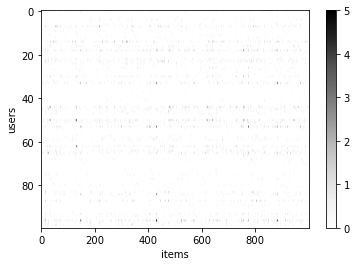

In [2]:
# Constants
N = 100   # num "users"
M = 1000  # num "items"
K = 5     # number of latent factors

# Hyperparameters
alpha = 0.1  # sparse gamma prior with mean alpha/beta 
beta = 1.0

# Make random keys to sample the model
rng1, rng2, rng3 = jr.split(jr.PRNGKey(0), 3)

# TFD sampling is throwing weird warnings today so use jr instead
# theta = tfd.Gamma(alpha, rate=beta).sample(sample_shape=(N, K), seed=rng1)
# eta = tfd.Gamma(alpha, rate=beta).sample(sample_shape=(M, K), seed=rng2)
# data = tfd.Poisson(theta @ eta.T).sample(seed=rng3)
theta = jr.gamma(rng1, alpha, shape=(N, K)) / beta
eta = jr.gamma(rng2, alpha, shape=(M, K)) / beta
data = jr.poisson(rng3, theta @ eta.T, shape=(N, M))

# Plot the data matrix
plt.imshow(data, aspect="auto", vmax=5, cmap="Greys")
plt.xlabel("items")
plt.ylabel("users")
plt.colorbar()

print("Max data:  ", data.max())
print("num zeros: ", np.sum(data == 0))

# Approach 2: Use Tensorflow Probability classes

In [3]:
def gamma_expected_log(gamma):
    """Helper function to compute expected log under gamma distribution.
    """
    return spsp.digamma(gamma.concentration) - np.log(gamma.rate)

def expected_poisson_logpdf(x, expected_rate, expected_log_rate):
    """Helper function to compute the expected logpdf under a Poisson.
    """
    return -spsp.gammaln(x + 1) + x * expected_log_rate - expected_rate


In [4]:
def cavi(data, 
         num_factors=10, 
         num_iters=200, 
         tol=1e-5, 
         alpha_theta=0.1,
         beta_theta=1.0,
         alpha_eta=0.1,
         beta_eta=1.0,
         seed=0
        ):
    """Run coordinate ascent VI for Poisson matrix factorization.
    """
    data = data.astype(np.float32)
    N, M = data.shape
    K = num_factors      # short hand
    
    def cavi_step(q_z, q_theta, q_eta):
        """One step of CAVI.
        """
        # Update the topic assignment counts
        E_logtheta = gamma_expected_log(q_theta)
        E_logeta = gamma_expected_log(q_eta)
        q_z = tfd.Multinomial(data, logits=E_logtheta[:, None, :] + E_logeta)
        
        # Compute the mean of q(z) since we'll use it twice below
        E_z = q_z.mean()
        
        # Update the per-user posterior
        q_theta = tfd.Gamma(alpha_theta + E_z.sum(axis=1), 
                            beta_theta + q_eta.mean().sum(axis=0))
        
        # Update the per-item posterior
        q_eta = tfd.Gamma(alpha_eta + E_z.sum(axis=0), 
                          beta_eta + q_theta.mean().sum(axis=0))
        
        return q_z, q_theta, q_eta
    
    def elbo(key, q_z, q_theta, q_eta):
        """Compute the evidence lower bound.
        
        key: a jr.PRNGKey in case you need to use a Monte Carlo
             estimate of the ELBO.
        
        q_z, q_theta, q_eta: posterior approximations.
        """
        elbo = 0
        
        # KL to prior
        elbo -= q_theta.kl_divergence(tfd.Gamma(alpha_theta, beta_theta)).sum()
        elbo -= q_eta.kl_divergence(tfd.Gamma(alpha_eta, beta_eta)).sum()
        
        # Compute expectations for E_q[log p(z | \theta, \eta)]
        E_logtheta = gamma_expected_log(q_theta)
        E_logeta = gamma_expected_log(q_eta)
        E_log_rate = E_logtheta[:, None, :] + E_logeta
        E_rate = q_theta.mean()[:, None, :] * q_eta.mean()
        
        # Approximate E_q[log p(z | \theta, \eta)] by plugging in E_q[z] rather
        # than taking an expectation over z. This should be close but not exactly 
        # the ELBO, so it might not *strictly* increase!
        elbo += expected_poisson_logpdf(q_z.mean(), E_rate, E_log_rate).sum()
        
        return elbo / np.sum(data)
    
    # Initialize the variational posteriors.
    # Note: it's a good idea to randomize these in practice!
    key = jr.PRNGKey(seed)
    q_theta = tfd.Gamma(alpha_theta * np.ones((N, K)), beta_theta * np.ones((N, K)))
    q_eta = tfd.Gamma(alpha_eta * np.ones((M, K)), beta_eta * np.ones((M, K)))
    q_z = tfd.Multinomial(data, logits=np.zeros((N, M, K)))
    
    # Run CAVI
    key, elbo_key = jr.split(key)
    elbos = [elbo(elbo_key, q_z, q_theta, q_eta)]
    for itr in trange(num_iters):
        q_z, q_theta, q_eta = cavi_step(q_z, q_theta, q_eta)
        
        # Compute a Monte Carlo approximation of the ELBO
        key, elbo_key = jr.split(key)
        elbos.append(elbo(elbo_key, q_z, q_theta, q_eta))
        
    return np.array(elbos), (q_z, q_theta, q_eta)
        

In [5]:
elbos, (q_z, q_theta, q_eta) = cavi(data)

Text(0, 0.5, 'ELBO per entry')

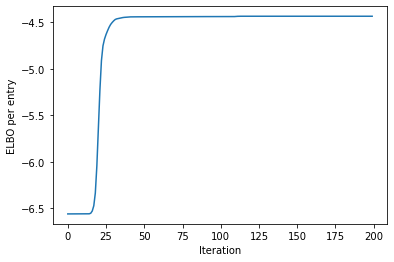

In [6]:
plt.plot(elbos[1:])
plt.xlabel("Iteration")
plt.ylabel("ELBO per entry")

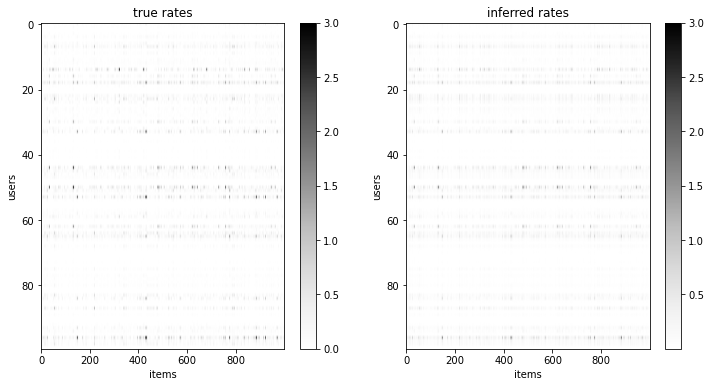

In [7]:
true_rates = theta @ eta.T
inf_rates = q_theta.mean() @ q_eta.mean().T

# Plot the data matrix
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(true_rates, aspect="auto", vmax=3, cmap="Greys")
plt.xlabel("items")
plt.ylabel("users")
plt.title("true rates")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(inf_rates, aspect="auto", vmax=3, cmap="Greys")
plt.xlabel("items")
plt.ylabel("users")
plt.title("inferred rates")
plt.colorbar()
